In [65]:
#!/usr/bin/env python

In [66]:
"""Unsupervised Learning with SciKit-Learn: Clustering"""

'Unsupervised Learning with SciKit-Learn: Clustering'

# Lesson 11 Assignment

In [67]:
import warnings
import pandas as pd
import numpy as np
from statistics import median
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import mutual_info_score, adjusted_rand_score, silhouette_score, homogeneity_score, completeness_score

In [68]:
warnings.filterwarnings('ignore')

In [69]:
data = pd.read_csv('seeds_dataset.csv', names=['area', 'perimeter', 'compactness', 'kernel_len', 'kernel_width', 'asym_coef', 'kernel_groove_len', 'label'], index_col=False)

## 1. Explore the data set (10 points)

In [70]:
data.head()

,area,perimeter,compactness,kernel_len,kernel_width,asym_coef,kernel_groove_len,label
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [72]:
data.describe()

,area,perimeter,compactness,kernel_len,kernel_width,asym_coef,kernel_groove_len,label
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


Taking a look at the descriptive statistics, we can see there are 210 observations. There isn't much variance in the data as most of the standard deviations are small and near each other. The column with the most variance is `area`. The values of `area` and `perimeter` are much greater than all the other columns.

In [71]:
data.label.value_counts()

label
1    70
2    70
3    70
Name: count, dtype: int64

The counts of each label are equal.

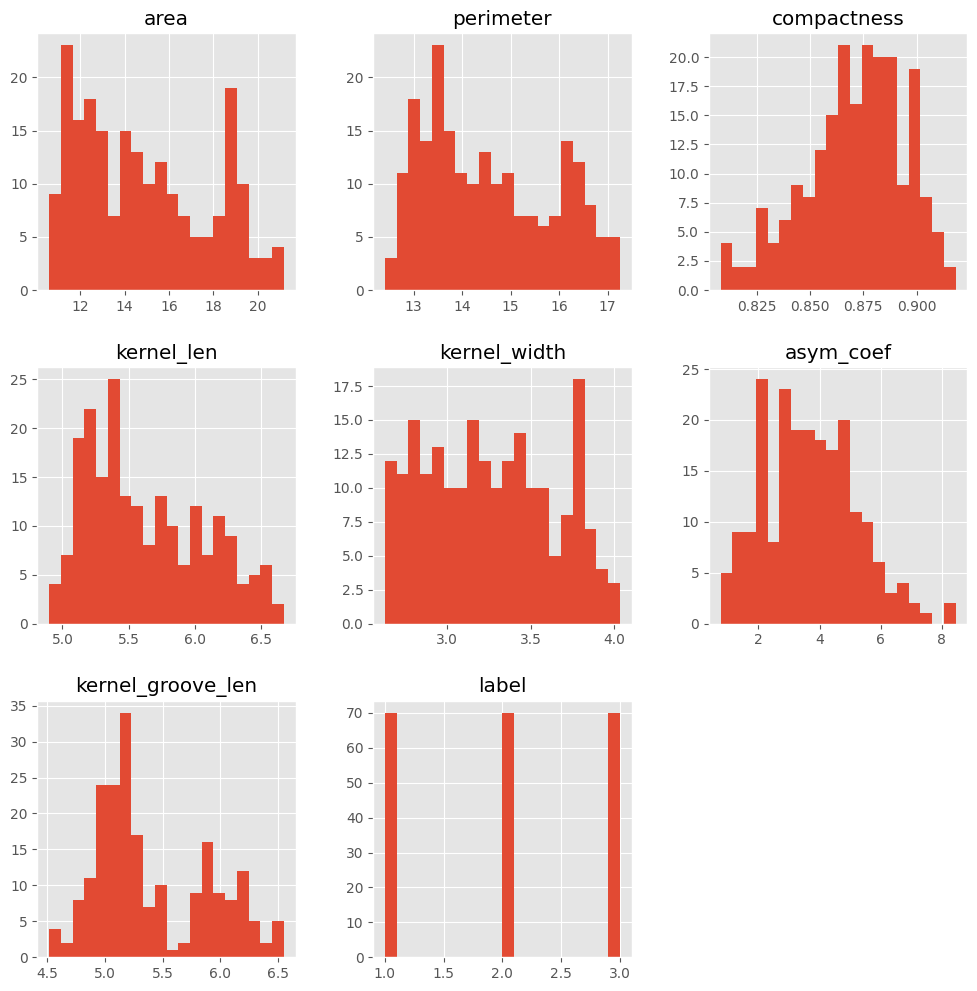

In [73]:
data.hist(figsize=(12,12),bins=20)
plt.show()

Taking a look at the distributions of each column, we can see that each of the column have a slight skew present.

In [74]:
data[data.isnull().any(axis=1)]

,area,perimeter,compactness,kernel_len,kernel_width,asym_coef,kernel_groove_len,label


There doesn't appear to be any null values in the data.

Text(0.5, 0, 'Predicted Label')

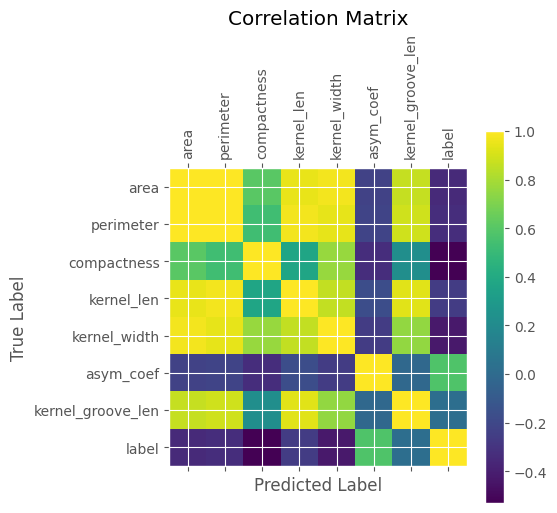

In [75]:
plt.matshow(data.corr())
plt.title('Correlation Matrix')
plt.colorbar()
plt.xticks(range(8), list(data.columns), rotation=90)
plt.yticks(range(8), list(data.columns))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

We can see lots of correlation between many of our variables. This is because the variables are not truly independent of each other. For example, area and perimeter are both linear combinations of the kernel's length and width. The kernel's compactness is also dependent upon the area and perimeter of the kernel. We can see the relationships between these variables using the scatterplot matrix pictured below.

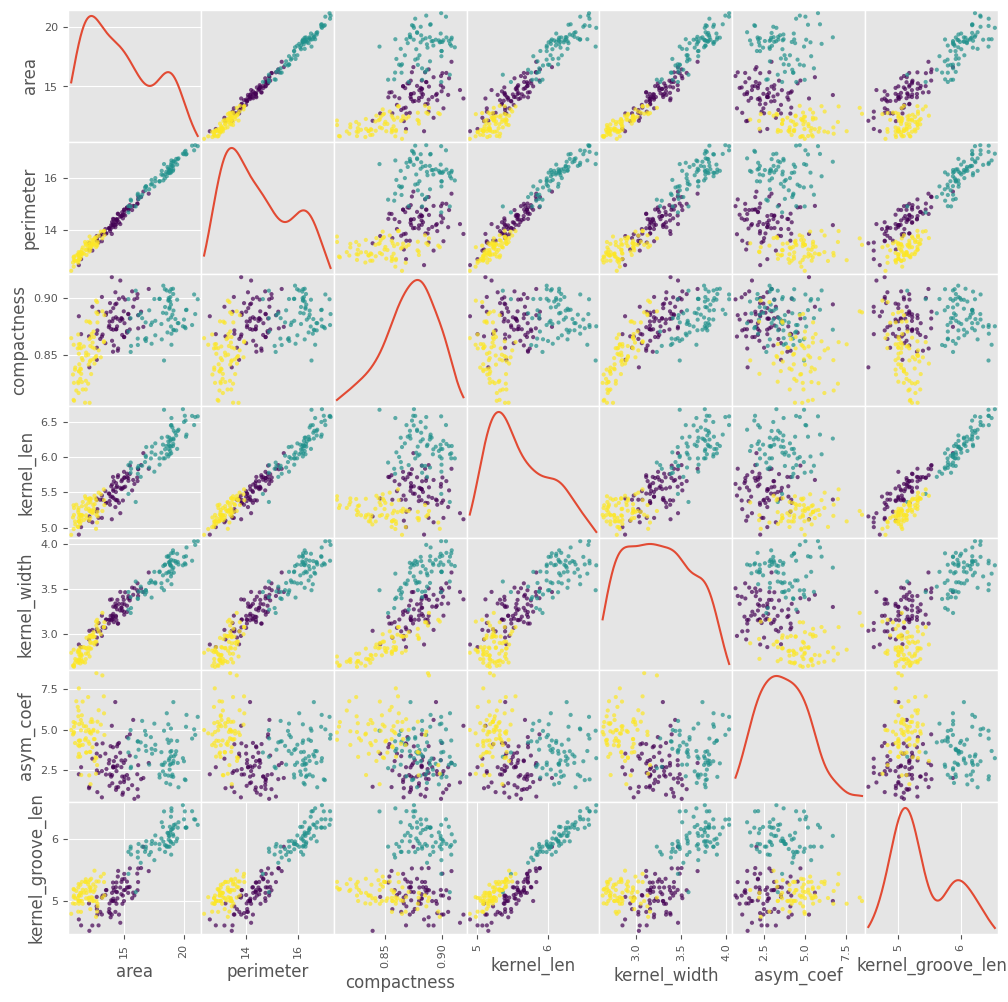

In [76]:
pd.plotting.scatter_matrix(data.drop('label', axis=1), alpha = 0.7, figsize = (12, 12), diagonal = 'kde', c=data.label)
plt.style.use('ggplot')
plt.show()

This matrix further supports our observations made from the correlation matrix.We can observe a linear relationship between `area`, `perimeter`, `kernel_len`, and `kernel_width`. The relationship between `compactness` and other variables are not linear, however, we can notice a steep increasing relationship, similar to that of exponential growth. The only independent variable with very little relation to other variables is `asym_coef`.

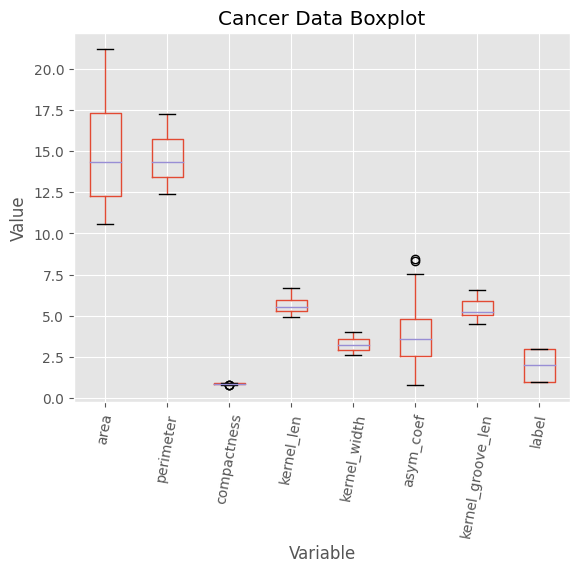

In [77]:
data.boxplot()
plt.title('Cancer Data Boxplot')
plt.ylabel('Value')
plt.xlabel('Variable')
plt.xticks(rotation=80)
plt.show()

By observing the boxplot, we can see there are quite a few outliers in the data. We can use the helper function `reset_outliers` to treatment the observations with extreme values. The function identifies values in each column that are greater than or less than three standard devations of the mean, then replaces these values with the median of its respective column

In [78]:
def remove_outliers(data):
  """finds and resets outliers in a column"""
  for i in data.columns:
    print(i)
    q1 = np.quantile(data[i], .25)
    q3 = np.quantile(data[i], .75)
    iqr = q3 - q1
    print(data[(data[i] <= q1-(1.5*iqr)) | (data[i] >= q3+(1.5*iqr))])
    data = data.drop(data[(data[i] <= q1-(1.5*iqr)) | (data[i] >= q3+(1.5*iqr))].index)
  return data

In [79]:
data = remove_outliers(data)

area
Empty DataFrame
Columns: [area, perimeter, compactness, kernel_len, kernel_width, asym_coef, kernel_groove_len, label]
Index: []
perimeter
Empty DataFrame
Columns: [area, perimeter, compactness, kernel_len, kernel_width, asym_coef, kernel_groove_len, label]
Index: []
compactness
      area  perimeter  compactness  kernel_len  kernel_width  asym_coef  \
157  12.13      13.73       0.8081       5.394         2.745      4.825   
158  11.75      13.52       0.8082       5.444         2.678      4.378   
174  10.83      12.96       0.8099       5.278         2.641      5.182   

     kernel_groove_len  label  
157              5.220      3  
158              5.310      3  
174              5.185      3  
kernel_len
Empty DataFrame
Columns: [area, perimeter, compactness, kernel_len, kernel_width, asym_coef, kernel_groove_len, label]
Index: []
kernel_width
Empty DataFrame
Columns: [area, perimeter, compactness, kernel_len, kernel_width, asym_coef, kernel_groove_len, label]
Index: []
asym

Based on the printed output of out `remove_outliers` function, we can see that 5 rows have been removed. Their indices are 157, 158, 174, 203, and 207.

## 2. Use K-means clustering to group the seed data. (30 points)


The first step in building clustering models is to preprocess the data. We can do this by using `MinMaxScaler` to scale to data to values between 0 and 1.

In [80]:
scaler = MinMaxScaler()
X = scaler.fit_transform(data.iloc[:, 0:7])
y = data.label

In [81]:
kmeans = KMeans(n_clusters=3, random_state=17)
kmeans.fit(X)
y_pred = kmeans.predict(X)

In [82]:
mutual_info_score(y, y_pred)

0.7339735874129178

Once the data is scaled, we can use `KMeans` to create our first clustering model. We set the n_clusters parameter to 3, representing our 3 groups we would like to label. Then we will fit and predict labels with the model using our scaled data. The model yielded a mutual information based score of .73. This suggests that about 73% of the predicted labels agree with the true labels of the data.

In [83]:
centers = kmeans.cluster_centers_
center_l = centers[:, 3]
center_w = centers[:, 4]

Let's visualize the predicted clusters in comparison to our true clusters. We will also get the centers of each cluster used by the model.

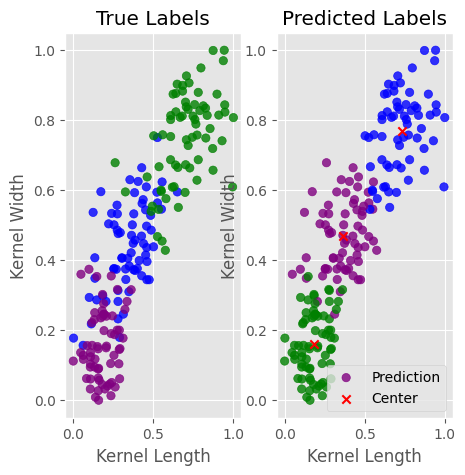

In [91]:
colors = ('blue', 'green', 'purple')

plt.figure(figsize=(5,5))

plt.subplot(121)
plt.scatter(X[:,3], X[:, 4], c=data.label, cmap=ListedColormap(colors), alpha=0.8)
plt.title('True Labels')
plt.xlabel('Kernel Length')
plt.ylabel('Kernel Width')

plt.subplot(122)
plt.scatter(X[:,3], X[:, 4], c=y_pred, label='Prediction', cmap=ListedColormap(colors), alpha=0.8)
plt.scatter(center_l, center_w, marker='x', c='r', label='Center')
plt.title('Predicted Labels')
plt.xlabel('Kernel Length')
plt.ylabel('Kernel Width')

plt.style.use('ggplot')
plt.legend()
plt.show()

Taking a look at the true and predicted clusters, we can see the centers are fairly representative of the groups. The data points closer to the center are correct, however, data points that lie in between two clusters are mislabeled.

## 3. Use different linkage type for Hierarchical clustering to the seed data, which linkage type give the best result? (30 points)

We will use a manual grid search to build hierarchical clustering models using each of the three linkage types. We will use a data frame to store various metrics we'll use to compare the performance of each of the models.

In [85]:
linkage_types = ['average', 'complete', 'ward']

In [86]:
df = pd.DataFrame(columns=['linkage', 'homogeneity', 'completeness', 'adjusted rand', 'silhouette'])
for i in linkage_types:
  row = []
  row.append(i)
  pred_temp = AgglomerativeClustering(n_clusters=3, linkage=i, affinity='euclidean').fit_predict(X)
  row.append(homogeneity_score(y, pred_temp))
  row.append(completeness_score(y, pred_temp))
  row.append(adjusted_rand_score(y, pred_temp))
  row.append(silhouette_score(X, pred_temp, metric='euclidean'))
  df.loc[len(df.index)] = row

In [87]:
df

,linkage,homogeneity,completeness,adjusted rand,silhouette
0,average,0.760993,0.760593,0.807357,0.407685
1,complete,0.644608,0.653577,0.594263,0.387032
2,ward,0.682680,0.685195,0.704173,0.395935


We can clearly see that the model built with the 'average' linkage type outperforms all other models. Although the silhouette scores of the models are not excellent, the 'average' model came out on top.

## 4. Use DBscan clustering group the seed data and find the best epses and min_samples value. (30 points)

In [92]:
epses = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
min_samples = [5, 10, 15]
results = []
for e in epses:
  for s in min_samples:
    model = DBSCAN(eps=e, min_samples=s)
    y_pred_temp = model.fit_predict(X)
    n_clusters = np.unique(model.labels_).size
    if n_clusters > 1:
      score = silhouette_score(X, y_pred_temp, metric='euclidean')
      results.append((e, s, n_clusters, score))
results

[(0.2, 5, 5, 0.023847301280480182),
 (0.2, 10, 4, 0.10213446913058502),
 (0.2, 15, 3, -0.21152635866997102),
 (0.3, 5, 2, 0.015920989872635242),
 (0.3, 10, 2, 0.06966608841643415),
 (0.3, 15, 2, 0.1526582429889941)]

The results from the DBSCAN model are very interesting. Firstly, majority of the parameter combinations returned a model with less than two clusters. As you can see in our code, we only computed the silhouette score for models with at least 2 clusters. Of the models that had 2 or more clusters, none of them yielded a silhouette score that demonstrated 'good' performance. However, the model with epses and min_sample values of 0.3 and 15 yielded the best silhouette score. Interestingly, the only model that had the correct number of clusters returned the worst silhouette score. It is also worth noting that the model that yielded the greatest silhouette score only used 2 clusters. This may be due to the fact that the three clusters overlap eachother greatly.